In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer, RobustScaler
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
# from dython.nominal import associations

%matplotlib inline

c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def export_to_kaggle_submission(test_df: pd.DataFrame, y_pred_scaled: pd.Series, filename: str):
    y_pred = np.expm1(y_pred_scaled)
    y_pred[y_pred < 0] = 0

    test_df['predicted'] = y_pred
    test_df.index.names = ['id']
    test_df['predicted'].to_csv(f"../../delivery/predictions/{filename}.csv")

In [3]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    y_pred[y_pred < 0] = 0
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [4]:
all_data = pd.read_csv("../../own_data/all_with_stores_pop.csv")
all_data.set_index(["dataset", "range_index"], inplace=True)
all_data['in_mall'] = all_data['mall_name'].notna()
all_data['in_chain'] = all_data['chain_name'].notna()
# all_data['stopplace_type'] = all_data['stopplace_type'].fillna("Mangler type")
all_data['mall_name'] = all_data['mall_name'].fillna("None")
# all_data['address'] = all_data['address'].fillna("None")
# all_data['stopplace_type'] = all_data['stopplace_type'].fillna("None")
# all_data['stopplace_type'] = all_data['stopplace_type'].fillna("None")
all_data['as'] = all_data['store_name'].str.contains(r"\b(AS)\b", case=False, regex=True)
all_data['chain_name'] = all_data['chain_name'].fillna("None")
all_data['busstop_id'] = all_data['busstop_id'].map(str)
all_data['lv1'] = all_data['lv1'].map(str)
all_data['lv2'] = all_data['lv2'].map(str)
all_data['lv3'] = all_data['lv3'].map(str)
all_data['lv4'] = all_data['lv4'].map(str)
all_data.drop(columns=[
  
    'store_name',
    'address',
    'importance_level',
    'busstop_id', 
    'other_stores_50', 
    'buss_stops_300', 
    'municipality_name', 
    'lv1', 
    'lat', 
    'couple_children_6_to_17_years', 
    'couple_without_children_x', 
    'single_parent_children_0_to_5_years', 
    'singles_x', 
    'singles_y', 
    'couple_without_children_y', 
    'couple_with_children', 
    'district_age_0-14_distribution', 
    'district_age_65-90_distribution', 
    'grunnkrets_population', 
    'municipality_density', 
    'all_households', 
    'lv2_population_district_div_count_stores', 
    'lv1_population_municipality_div_count_stores', 
    'lv2_population_municipality_div_count_stores', 
    'in_mall', 
    'lv3_population_district_div_count_stores', 
    'district_name', 
    'num_of_buss_stops_closer_that_1000_to_busstop', 
    'municipality_age_0-14_distribution', 
    'municipality_age_35-64_distribution', 
    'municipality_age_65-90_distribution', 
    
  #   'store_name', 
  #   'stopplace_type', 
  #   'address', 
  #   "importance_level", 
  #   "mall_name", 
  #   "busstop_id", 
  #   # 'other_stores_50', 'buss_stops_1000', 'buss_stops_300',
  #   # "municipality_name", 
  #   "lv1", 
  #   "lv2", 
  #  #  "lv3", 
  #   "grunnkrets_id", 
  #  #  'distance_closest_busstop',
  #   "lat", 
  #   "lon", 
  #   "area_km2", 
  #   # 'other_stores_50', 
  #   # 'buss_stops_1000', 'couple_children_0_to_5_years', 'couple_children_18_or_above',
  #   'couple_children_6_to_17_years', 'couple_without_children_x',
  #   'single_parent_children_0_to_5_years',
  #   'single_parent_children_18_or_above',
  #   'single_parent_children_6_to_17_years', 'singles_x', 'singles_y', 'couple_without_children_y', 'couple_with_children',
  #   'other_households', 
  #   'single_parent_with_children',
  #   'couple_children_0_to_5_years', 'couple_children_18_or_above',
  #   'side_placement',
  #     #  'num_of_buss_stops_close', 
  #     #  'district_age_0-14_distribution',
  #     #  'district_age_15-34_distribution', 'district_age_35-64_distribution',
  #     #  'district_age_65-90_distribution', 
  #     'grunnkrets_population',
  #     #  'municipality_density', 
  #     #  'district_density',
  #      'all_households',
  #       'lv1_population_district_div_count_stores',
  #      'lv2_population_district_div_count_stores',
  #      'lv1_population_municipality_div_count_stores',
  #      'lv2_population_municipality_div_count_stores',
  #      'in_mall',
  #     #  'lv3_population_district_div_count_stores',
  #     #  'lv4_population_district_div_count_stores',
  #     #  'lv3_population_municipality_div_count_stores',
  #     #  'lv4_population_municipality_div_count_stores',
  #   # 'other_stores_1000', 
  #   # 'other_stores_250',
  #  #  'municipality_population', 
  #  #  'district_population', 
  #  #  'other_stores_100',

  #   'district_area',
  #   'municipality_area',
  #   # 'in_mall',
  #     #  'in_chain',
  #   # 'buss_stops_300'
   #  'lv3'

    ], inplace=True)

data_with_label = all_data.loc[["train"]]

data_with_label.set_index('store_id', inplace=True)
data_without_label = all_data.loc[['test']]
data_without_label.set_index('store_id', inplace=True)
data_without_label.drop(columns=["revenue"], inplace=True)

X, y = data_with_label.loc[:, data_with_label.columns != 'revenue'], data_with_label['revenue']

data_train, data_test = train_test_split(data_with_label, test_size=0.2, random_state=42)

X_train, y_train = data_train.loc[:, data_train.columns != 'revenue'], data_train['revenue']
X_test, y_test = data_test.loc[:, data_test.columns != 'revenue'], data_test['revenue']
test_x_lv4 =[]
test_y_lv4 = []
# d = ["1.1.6.2"]
plaace_lv4 = ['1.1.1.0', '1.1.2.0', '1.1.3.0', '1.1.4.0', '1.1.5.0', '1.1.6.1',
       '1.1.6.2', '1.1.6.3', '1.1.6.4', '1.1.7.0', '1.1.9.0', '1.2.1.0',
       '1.2.2.0', '1.2.3.0', '1.2.4.0', '1.3.1.0', '1.3.2.0', '1.4.1.0',
       '1.4.2.0', '2.1.1.0', '2.1.2.0', '2.1.3.0', '2.1.4.0', '2.1.5.0',
       '2.1.6.0', '2.1.7.0', '2.2.1.0', '2.2.2.0', '2.2.4.0', '2.3.1.0',
       '2.3.2.0', '2.3.3.0', '2.3.4.0', '2.3.5.0', '2.4.1.0', '2.4.2.0',
       '2.4.3.0', '2.4.4.0', '2.4.5.0', '2.4.6.0', '2.5.2.0', '2.6.1.0',
       '2.6.2.0', '2.6.3.1', '2.6.3.2', '2.6.3.3', '2.6.4.0', '2.6.5.0',
       '2.6.6.1', '2.6.6.2', '2.7.1.0', '2.7.2.0', '2.7.3.0', '2.7.4.0',
       '2.7.5.0', '2.7.6.0', '2.8.1.0', '2.8.10.0', '2.8.11.2', '2.8.2.0',
       '2.8.3.0', '2.8.4.0', '2.8.5.0', '2.8.6.0', '2.8.7.0', '2.9.1.0',
       '2.9.2.0', '2.9.3.0', '2.9.4.0', '2.9.5.0', '2.9.7.0', '2.9.8.0',
       '2.9.9.0', '3.2.1.0', '3.2.2.0', '3.2.4.0', '3.3.2.0', '3.3.3.0',
       '3.3.4.0', '3.3.5.0', '3.3.6.0', '3.3.7.0', '3.4.2.0', '3.4.3.0',
       '3.6.1.0']
# for lv_4 in plaace_lv4:
#    lv4_data = data_test[data_test["lv4"] == lv_4]
#    test_slit_x_lv4, test_split_y_lv4 = lv4_data.loc[:, lv4_data.columns != 'revenue'], lv4_data['revenue']
#    test_x_lv4.append(test_slit_x_lv4)
#    test_y_lv4.append(test_split_y_lv4)
y_train_scaled = np.log1p(y_train)
y_test_scaled = np.log1p(y_test)
y_scaled = np.log1p(y)


# Comment in this when testing on test dataset to kaggle
X_train = X
y_train = y
y_train_scaled = y_scaled
X_test = data_without_label

C:\Users\haako\AppData\Local\Temp\ipykernel_8888\2687984171.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_data['as'] = all_data['store_name'].str.contains(r"\b(AS)\b", case=False, regex=True)


In [5]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_features = list(numeric_features.to_numpy())

print(numeric_features)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())]
)

categorical_features = X_train.select_dtypes(include=[np.object0]).columns
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(fill_value="missing", strategy="constant")),
        ("onehotencoding", OneHotEncoder(handle_unknown="ignore"))
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)

categorical_features_include_bool = list(categorical_features.to_numpy())
categorical_features_include_bool.extend(list(X.select_dtypes(include=[np.bool8]).columns.to_numpy()))
# categorical_transformer_ordinal = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
# preprocessor_ordinal = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_features),
#         ("cat", categorical_transformer_ordinal, categorical_features_include_bool)
#     ],
#     remainder="passthrough",
# )


['grunnkrets_id', 'lon', 'other_stores_1000', 'other_stores_100', 'other_stores_250', 'buss_stops_1000', 'grunnkrets_1', 'distance_closest_busstop', 'area_km2', 'couple_children_0_to_5_years', 'couple_children_18_or_above', 'single_parent_children_18_or_above', 'single_parent_children_6_to_17_years', 'other_households', 'single_parent_with_children', 'district_age_15-34_distribution', 'district_age_35-64_distribution', 'municipality_age_15-34_distribution', 'district_population', 'municipality_population', 'district_area', 'municipality_area', 'district_density', 'lv1_population_district_div_count_stores', 'lv4_population_district_div_count_stores', 'lv3_population_municipality_div_count_stores', 'lv4_population_municipality_div_count_stores']


In [8]:
# is used for feature selection in select from model in other models later. Is prefitted so that we do not need to fit again for all models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
X_train_ft = preprocessor.fit_transform(X_train)
X_test_ft = preprocessor.transform(X_test)

grad_boost_regressor_prefitted = GradientBoostingRegressor(
   random_state=42, 
        max_depth=2,
        learning_rate=.10526, 
        min_samples_leaf=3,
        n_estimators=929, 
        loss="squared_error"
    )
grad_boost_regressor_prefitted = grad_boost_regressor_prefitted.fit(X_train_ft, y_train_scaled)
# y_hat_trees = grad_boost_regressor_prefitted.predict(X_test_ft)
# print(rmsle(y_test, np.expm1(y_hat_trees)))

In [11]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
forest = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("randomforestregressor", 
    RandomForestRegressor(
        random_state=42, 
        max_depth=15, 
        n_estimators=500, 
        criterion="squared_error"))]
)
adaboost = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("adaboostregressor", 
    AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, criterion="squared_error", random_state=42), 
        random_state=42, 
        learning_rate=.01, 
        n_estimators=50, 
        loss="linear"))]
)
gradboost = Pipeline(
    steps=[("preprocessor", preprocessor), 
    # ("select", 
    # SelectFromModel(SVR(kernel="linear"))),
    # ("pca", PCA(n_components=500)),
    ("gradientboostingregressor", 
    GradientBoostingRegressor(
        random_state=42, 
        max_depth=3,
        learning_rate=.05, 
        n_estimators=1000, 
        loss="huber"))]
)
extratreees = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("extratreesregressor", 
    ExtraTreesRegressor(
        random_state=42, 
        n_estimators=1000,
        max_depth=18, 
        criterion="squared_error"))]
)
histgradboost = Pipeline(
    steps=[("preprocessor", preprocessor),
    ("histgradientboostingregressor", 
    HistGradientBoostingRegressor(
        random_state=42, 
        learning_rate=.02, 
        max_depth=3,
        loss="poisson",
        max_iter=1000,
        scoring="rmse"
        )
    )]
)
bagging = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("baggingregressor", 
    BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=12, criterion="squared_error", random_state=42), 
        random_state=42, 
        n_estimators=100,
        max_samples=.8,
        max_features=.8))]
)
sdg = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("sdgregressor", 
    SGDRegressor(
        loss='epsilon_insensitive', 
        penalty="elasticnet",
        max_iter=2000,
        learning_rate="adaptive",
        early_stopping=True,
        tol=0.0001,
        random_state=42))]
)
kernel = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("kernelridge", 
    KernelRidge(degree=5))]
)
knn = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("knn", 
    KNeighborsRegressor(
        n_neighbors=30,
        weights="uniform"))]
)
svr = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("SVR", 
    SVR(
        C= 1.0481516144339662,
        gamma='auto',
        tol=1.011931105515637e-05,
        kernel='linear',
        shrinking=False,
        epsilon=0.4803902306617546,
    ))]
)
# tpot = Pipeline(
#     steps=[("preprocessor", preprocessor), 
#     ("tpot", 
#     TPOTRegressor(config_dict="TPOT sparse", generations=1))]
# # )

# IS COMMENT OUT SINCE extra_trees NEEDS TO BE FITTED IF THIS MODEL SHALL BE USED
mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
    ("grad", SelectFromModel(grad_boost_regressor_prefitted, threshold="0.25*mean", prefit=True)),
    ("mlp", 
    MLPRegressor(
        activation='logistic', 
        # alpha=6.0378e-07, 
        alpha=.05,
        batch_size='auto', 
        beta_1=0.9, 
        beta_2=0.999, 
        early_stopping=True, 
        epsilon=1e-08, 
        hidden_layer_sizes=(3,),
        learning_rate_init=0.000112073, 
        # learning_rate_init=0.1,
        n_iter_no_change=32, 
        shuffle=True, 
        solver='adam', 
        tol=0.0001, 
        validation_fraction=0.1, 
        max_iter=30000,
        random_state=42))]
)

cat = CatBoostRegressor(loss_function="RMSE", eval_metric="RMSLE")

X_train_light = X_train.copy()
X_test_light = X_test.copy()
for feature in categorical_features_include_bool:
    X_train_light[feature] = pd.Series(X_train_light[feature], dtype="category")
    X_test_light[feature] = pd.Series(X_test_light[feature], dtype="category")
lgb_train = lgb.Dataset(X_train_light, y_train_scaled)
lgb_eval = lgb.Dataset(X_test_light, y_test_scaled, reference=lgb_train)

In [12]:
X_train_ft = preprocessor.fit_transform(X_train)
X_test_ft = preprocessor.transform(X_test)

In [9]:
params = {
    'objective': "huber",
    'metric': 'rmse',
    'max_depth': 20,
    'num_leaves': 50,
    'learning_rate': 0.01,
    'tree_learner': 'feature',
    'colsample_bytree': .8,
    'subsample': 1.,
    'drop_rate': .2,
    "num_iterations": 600,
    'subsample_freq': 10,
    'verbose': 0,
    'seed': 42,

}
lgb_model = lgb.LGBMRegressor(**params
)
lgb_model.fit(X_train_ft, y_train_scaled)


# import warnings
# with warnings.catch_warnings():
#     s = cross_val_score(lgb_model, X_train_ft, y_train_scaled, cv=5, scoring="neg_root_mean_squared_error")
#     print(s, s.mean())


    # just to supress warning
    # warnings.filterwarnings("ignore")
    # grid = GridSearchCV(lgb_model, param_grid=params_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
    # grid.fit(X_train_light, y_train_scaled, eval_set=[(X_test_light, y_test_scaled)], eval_metric="rmse", verbose=False)
# print(grid.best_score_, grid.best_params_)
# print('Starting training...')
# # train
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=lgb_eval,
#                 # feval=rmsle_lgbm,
#                 callbacks=[lgb.early_stopping(stopping_rounds=100)]
#                 )
# lgb.plot_importance(gbm)
# feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X_train.columns)), columns=['Value','Feature'])

# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGBM Features')
# plt.tight_layout()
# plt.show()
# print('Saving model...')
# # save model to file
# gbm.save_model('model.txt')

# print('Starting predicting...')
# # predict
y_lightgbm = lgb_model.predict(X_test_ft)

print(rmsle(y_test, np.expm1(y_lightgbm)))

c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.755291818122066


Starting training...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008025 seconds.
You can set `force_col_wise=true` to remove the overhead.


c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


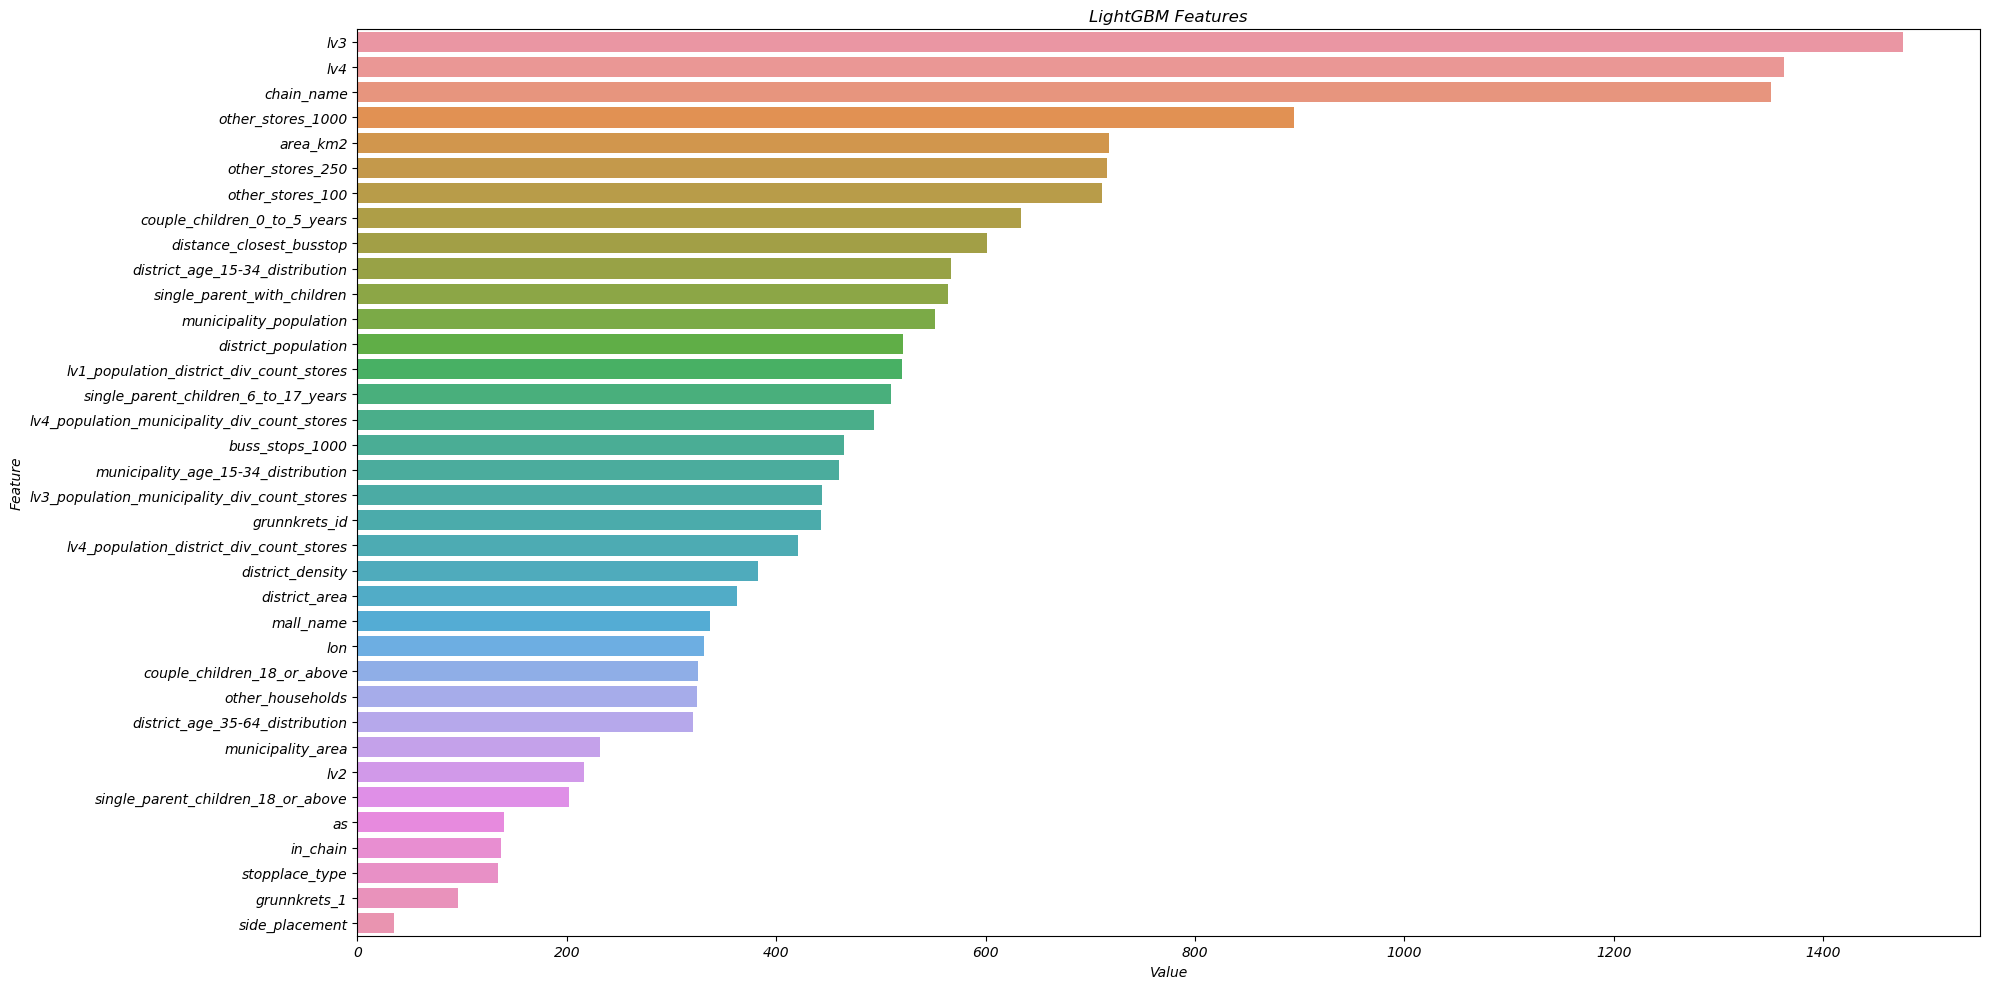

AssertionError: y_true and y_pred have different shapes

In [13]:
def rmsle_lgbm(y_pred, data):
    y_true = np.array(data.get_label())
    score = rmsle(y_true, y_pred)
    return 'rmsle', score, False

params_grid = {
    # 'boosting_type': ['dart'],
    'objective': ["huber", "fair", "l2", "l1"],
    'metric': ['rmse'],
    "num_iterations": [800],
    'max_depth': [15, 25],
    'num_leaves': [15, 30],
    'learning_rate': [0.01],
    'tree_learner': ['serial', 'feature'],
    "min_child_samples": [3,  8],
    'colsample_bytree': [ 1 ],
    'subsample': [.6, 1 ],
    # 'drop_rate': [.5,0.9],
    # 'xgboost_dart_mode': True,
    'subsample_freq': [10],
    'early_stopping_round': [100],
}

params = {
    # 'boosting_type': 'dart',
    'objective': "huber",
    # 'alpha': 0.9,
    'metric': 'rmse',
    'max_depth': 20,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'tree_learner': 'feature',
    'colsample_bytree': .8,
    'subsample': .9,
    'drop_rate': .2,
    # 'xgboost_dart_mode': True,
    "num_iterations": 600,
    'subsample_freq': 10,
    'verbose': 0,
    'seed': 42,

}
# params ={'metric': 'rmse', 'objective': 'huber', 'num_iterations': 951, 'learning_rate': 0.007446043298272433, 'tree_learner': 'serial', 'reg_alpha': 0.02978653021879073, 'reg_lambda': 5.040985148455079e-05, 'num_leaves': 52, 'colsample_bytree': 0.5793484710508887, 'subsample': 0.9237089671409163, 'subsample_freq': 3, 'min_child_samples': 7}
lgb_model = lgb.LGBMRegressor(**params
)
# lgb_model.fit(X_train_light, y_train_scaled, eval)
# import warnings
# with warnings.catch_warnings():
#     # s = cross_val_score(lgb_model, X_light, y_scaled, cv=5, scoring="neg_root_mean_squared_error")
#     # print(s, s.mean())
#     # just to supress warning
#     warnings.filterwarnings("ignore")
#     grid = GridSearchCV(lgb_model, param_grid=params_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
#     grid.fit(X_train_light, y_train_scaled, eval_set=[(X_test_light, y_test_scaled)], eval_metric="rmse", verbose=False)
#     print(grid.best_params_, grid.best_score_)
# print(grid.best_score_, grid.best_params_)
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                # num_boost_round=100,
                # valid_sets=lgb_eval,
                # feval=rmsle_lgbm,
                # callbacks=[lgb.early_stopping(stopping_rounds=100)]
                )
# lgb.plot_importance(gbm)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
# # # predict
y_lightgbm = gbm.predict(X_test_light)
print(rmsle(y_test, np.expm1(y_lightgbm)))
# print(rmsle(y_test, val_pred_scaled*CAT_SIZE))


In [11]:
for h in range(2,4,1):
    for k in range(2,10, 1):
        for i in range(2,9,1):
            for j in range(2,6,1):
                mlp = Pipeline(
                steps=[
                    ("preprocessor", preprocessor), 
                # ("extratrees", SelectFromModel(extra_trees, threshold="0.25*mean", prefit=True)),
                # ("pca", SelectFromModel(PCA())),
                ("mlp", 
                MLPRegressor(
                    activation='logistic', 
                    # alpha=6.0378e-07, 
                    alpha=.04,
                    batch_size=400, 
                    beta_1=0.9, 
                    beta_2=0.999, 
                    early_stopping=True, 
                    epsilon=1e-06, 
                    hidden_layer_sizes=(h, k,i,j),
                    # learning_rate_init=0.000112073, 
                    learning_rate_init=0.005,
                    n_iter_no_change=10, 
                    shuffle=True, 
                    solver='adam', 
                    tol=0.00001, 
                    validation_fraction=0.1, 
                    max_iter=500,
                    random_state=42))]
                )
                mlp.fit(X_train_ft, y_train_scaled)
                y_mlp = mlp.predict(X_test_ft)
                y_train_pred = mlp.predict(X_train_ft)
                print((h,k,i,j))
                print(rmsle(y_test, np.expm1(y_mlp)))
                print(rmsle(y_train, np.expm1(y_train_pred)))


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [10]:
mlp.fit(X_train, y_train_scaled)
y_mlp = mlp.predict(X_test)

In [11]:
print(rmsle(y_test, np.expm1(y_mlp)))

0.7575918041678151


In [102]:
tpot.fit(X_train, y_train_scaled)
y_tpot = tpot.predict(X_test)
print(rmsle(y_test, np.expm1(y_tpot)))

0.7061731333356819


In [29]:
svr.fit(X_train, y_train_scaled)
y_svr = svr.predict(X_test)
print(rmsle(y_test, np.expm1(y_svr)))



In [19]:
# rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [14]:
# X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train_scaled, test_size=0.2, random_state=42)
def objective_svr(trial):
    params = {
        'C': trial.suggest_float('C', 0, 3),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear']),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'epsilon': trial.suggest_float('epsilon', 0, 1),
    }
    svr = Pipeline(
        steps=[("preprocessor", preprocessor), 
        ("SVR", 
        SVR(**params))]
    )
    return cross_val_score(svr, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error').mean()

In [15]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(), direction="maximize"
)
study.optimize(objective_svr, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-28 08:55:07,527] A new study created in memory with name: no-name-614ca297-096e-443e-ab0e-974bd6651215
[I 2022-10-28 08:57:35,789] Trial 0 finished with value: -0.7606374190213991 and parameters: {'C': 1.8417111489550053, 'gamma': 'auto', 'tol': 0.0015170992564947855, 'kernel': 'linear', 'shrinking': True, 'epsilon': 0.7663737859883413}. Best is trial 0 with value: -0.7606374190213991.
[I 2022-10-28 09:08:39,174] Trial 1 finished with value: -0.7612227081207843 and parameters: {'C': 2.9634818626483224, 'gamma': 'scale', 'tol': 0.005822318551652181, 'kernel': 'linear', 'shrinking': False, 'epsilon': 0.647534753585721}. Best is trial 0 with value: -0.7606374190213991.
[I 2022-10-28 09:14:44,937] Trial 2 finished with value: -0.761393493655248 and parameters: {'C': 2.9846417547673667, 'gamma': 'scale', 'tol': 0.0007357343257516324, 'kernel': 'linear', 'shrinking': True, 'epsilon': 0.6369148147969047}. Best is trial 0 with value: -0.7606374190213991.
[I 2022-10-28 09:27:31,592] 

In [16]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train_scaled, test_size=0.2, random_state=42)
def objective_mlp(trial):
    params = {
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', [ 'adam']),
        'alpha': trial.suggest_float('alpha', 1e-7, 5e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'max_iter': trial.suggest_int('max_iter', 200, 30000),
        'shuffle': trial.suggest_categorical('shuffle', [True, False]),
        'random_state': 42,
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(3,)]),
        'beta_1': trial.suggest_float('beta_1', .8, .99, log=True),
        'beta_2': trial.suggest_float('beta_2', .99, .9999, log=True),


    }
    if params['solver'] == 'sdg' or  params['solver'] == 'adam':
        params['learning_rate_init'] = trial.suggest_float('learning_rate_init', 1e-7, 1e-1)
    select_mean = trial.suggest_float('select_mean', 0, 1)
    mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("grad", SelectFromModel(grad_boost_regressor_prefitted, threshold=f"{select_mean}*mean", prefit=False)),
        ("mlp", 
        MLPRegressor(**params))]
    )
   
    return cross_val_score(mlp, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error').mean()

In [17]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2), direction="maximize"
)
study.optimize(objective_mlp, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-31 10:11:23,164] A new study created in memory with name: no-name-5f70d7f5-13ac-4cf9-acc7-e26263724563
c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3,) which is of type tuple.
  warnings.warn(message)
[I 2022-10-31 10:15:56,831] Trial 0 finished with value: -0.7996648711096203 and parameters: {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006952452620847398, 'learning_rate': 'invscaling', 'max_iter': 8831, 'shuffle': False, 'hidden_layer_sizes': (3,), 'beta_1': 0.9044473891148123, 'beta_2': 0.9920082217745897, 'learning_rate_init': 0.06480415957475978, 'select_mean': 0.6223402985436989}. Best is trial 0 with value: -0.7996648711096203.
c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of 

KeyboardInterrupt: 

In [ ]:
def objective_grad(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'random_state': 42,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 10)

    }
    
    grad = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("mlp", 
        GradientBoostingRegressor(**params))]
    )
    return  cross_val_score(grad, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error').mean()

In [ ]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_grad, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-27 21:32:23,292] A new study created in memory with name: no-name-b39970b9-b023-4010-b5df-0a2b41bf8571
[I 2022-10-27 21:34:45,881] Trial 0 finished with value: 0.7744900812534281 and parameters: {'loss': 'huber', 'learning_rate': 0.016681691771281957, 'n_estimators': 694, 'criterion': 'friedman_mse', 'min_samples_leaf': 37, 'max_depth': 10}. Best is trial 0 with value: 0.7744900812534281.
[I 2022-10-27 21:35:50,207] Trial 1 finished with value: 0.9966015486857147 and parameters: {'loss': 'squared_error', 'learning_rate': 0.00013692606282170178, 'n_estimators': 799, 'criterion': 'squared_error', 'min_samples_leaf': 12, 'max_depth': 4}. Best is trial 0 with value: 0.7744900812534281.
[I 2022-10-27 21:36:17,690] Trial 2 finished with value: 0.7816033404030398 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.03783258124530899, 'n_estimators': 243, 'criterion': 'friedman_mse', 'min_samples_leaf': 44, 'max_depth': 6}. Best is trial 0 with value: 0.7744900812534281.
[I

Number of finished trials: 100
Best trial:
  Value: 0.7581332182349262
  Params: 
    loss: squared_error
    learning_rate: 0.10526284729579034
    n_estimators: 929
    criterion: friedman_mse
    min_samples_leaf: 3
    max_depth: 2


In [ ]:
def objective_forest(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'random_state': 42,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'n_jobs': -1,
    }
    if params['bootstrap'] == True:
        params['oob_score'] = trial.suggest_categorical('oob_score', [True, False])
        params['max_samples'] = trial.suggest_float('max_samples', 0.6, 1)

    forest = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("forest", 
        RandomForestRegressor(**params))]
    )
    return  cross_val_score(forest, X_train, y_train_scaled, cv=5, scoring='neg_root_mean_squared_error').mean()

In [ ]:
import optuna
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective_forest, n_trials=100, timeout=6000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objective(trial: optuna.Trial) -> float:
        param = {
                "loss_function": trial.suggest_categorical("loss_function", ["Huber:delta=0.5", "RMSE"]),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
                "depth": trial.suggest_int("depth", 1, 12),
                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
                "used_ram_limit": "3gb",
                "eval_metric": "RMSE",
                "verbose": 0,
        }
        if param["bootstrap_type"] == "Bayesian":
                param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
                param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

        cat = Pipeline(
        steps=[
                ("preprocessor", preprocessor), 
                ("catboost", 
                CatBoostRegressor(**params))]
        )
        # early_stopping_rounds=20)
        # s = cross_val_score(cat, X_train_ft, y_train_scaled, cv=8, scoring="neg_root_mean_squared_error", verbose=0)

        cross_

        return accuracy

In [145]:
for (c, t, s) in zip(d, te, ty):
    try:
        y_svr = svr.predict(t)
        print(c, rmsle(s, np.expm1(y_svr)), len(y_svr))
    except: 
        pass

1.1.1.0 0.614268541265045 8
1.1.2.0 1.3072511762552708 18
1.1.3.0 0.552742700690147 6
1.1.4.0 0.6691057102589212 7
1.1.5.0 0.6784469397551749 38
1.1.6.1 0.8851812603442731 33
1.1.6.2 0.8299178389321854 128
1.1.6.3 0.7879579361755121 22
1.1.6.4 0.7846799854851013 79
1.1.7.0 0.8247848256619178 88
1.1.9.0 0.6814576771336585 50
1.2.1.0 0.2628270116044473 1
1.2.2.0 0.9427724439339306 13
1.2.3.0 0.6240996325389649 12
1.2.4.0 0.6606814990273994 72
1.3.2.0 0.8364479035703286 54
1.4.1.0 0.30874085190891054 2
1.4.2.0 0.6822648792494045 2
2.1.1.0 1.0300485166738536 18
2.1.2.0 0.8181821243604397 24
2.1.3.0 0.9203760637011432 9
2.1.4.0 0.900610455664902 15
2.1.5.0 0.6253475127456882 2
2.1.6.0 0.9815051329180416 40
2.1.7.0 1.602810635258265 1
2.2.1.0 0.9278612558237663 74
2.2.4.0 1.04730004094861 6
2.3.1.0 1.0110781537564255 42
2.3.2.0 0.6279473351855087 19
2.3.3.0 0.22319709474627367 5
2.3.4.0 1.3363660498964998 12
2.3.5.0 1.154304262178181 4
2.4.1.0 0.24214618786783249 9
2.4.2.0 0.6153845780610633

In [18]:
%%time
knn.fit(X_train, y_train_scaled)
y_knn = knn.predict(X_test)
print(rmsle(y_test, np.expm1(y_knn)))

/lhome/haaknes/.local/lib/python3.10/site-packages/sklearn/neighbors/_base.py:513: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


ValueError: Metric 'minkowski' not valid for sparse input. Use sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute']) to get valid options. Metric can also be a callable function.

In [8]:
%%time
kernel.fit(X_train, y_train_scaled)
y_kernel = kernel.predict(X_test)
print(rmsle(y_test, np.expm1(y_kernel)))
kernel_str = [
'linear',
'cosine']
params = {'kernelridge__kernel': kernel_str,
        # 'kernelridge__kernel': []
    }
grid = GridSearchCV(kernel, params, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
grid.fit(X, y_scaled)

0.7263274519047543
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .......kernelridge__kernel=linear;, score=-0.805 total time=   7.4s
[CV 2/5] END .......kernelridge__kernel=linear;, score=-0.726 total time=   7.4s
[CV 3/5] END .......kernelridge__kernel=linear;, score=-0.710 total time=   7.3s
[CV 4/5] END .......kernelridge__kernel=linear;, score=-0.768 total time=   7.3s
[CV 5/5] END .......kernelridge__kernel=linear;, score=-0.776 total time=   7.3s
[CV 1/5] END .......kernelridge__kernel=cosine;, score=-0.840 total time=   7.4s
[CV 2/5] END .......kernelridge__kernel=cosine;, score=-0.761 total time=   7.3s
[CV 3/5] END .......kernelridge__kernel=cosine;, score=-0.741 total time=   7.3s
[CV 4/5] END .......kernelridge__kernel=cosine;, score=-0.797 total time=   7.3s
[CV 5/5] END .......kernelridge__kernel=cosine;, score=-0.824 total time=   7.3s
CPU times: user 2min 29s, sys: 19.9 s, total: 2min 49s
Wall time: 1min 31s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['other_stores_100',
                                                                          'distance_closest_busstop',
                                                                          'all_households',
                                                                          'num_of_buss_stops_close',
                                                                          'district_population',
                                                                          'district_area',
                                                                          'district_density']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['chain_name', 'district_name', 'municipality_name', 'lv4'], dtype='object'))])),
                                       ('kernelridge', KernelRidge(degree=5))]),
             param_grid={'kernelridge__kernel': ['linear', 'cosine']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [25]:
adaboost.fit(X_train, y_train_scaled)
y_ada = adaboost.predict(X_test)
print(rmsle(y_test, np.expm1(y_ada)))
params = {'adaboostregressor__base_estimator__max_depth':[11, 15],
          'adaboostregressor__base_estimator__min_samples_leaf':[5],
          'adaboostregressor__n_estimators':[20, 30],
          'adaboostregressor__learning_rate':[0.001, 0.01],
          'adaboostregressor__loss':['linear'],
    }
grid = GridSearchCV(adaboost, params, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
grid.fit(X, y_scaled)

0.7301436075113235
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END adaboostregressor__base_estimator__max_depth=11, adaboostregressor__base_estimator__min_samples_leaf=5, adaboostregressor__learning_rate=0.001, adaboostregressor__loss=linear, adaboostregressor__n_estimators=20;, score=-0.801 total time=   2.2s
[CV 2/5] END adaboostregressor__base_estimator__max_depth=11, adaboostregressor__base_estimator__min_samples_leaf=5, adaboostregressor__learning_rate=0.001, adaboostregressor__loss=linear, adaboostregressor__n_estimators=20;, score=-0.741 total time=   2.2s
[CV 3/5] END adaboostregressor__base_estimator__max_depth=11, adaboostregressor__base_estimator__min_samples_leaf=5, adaboostregressor__learning_rate=0.001, adaboostregressor__loss=linear, adaboostregressor__n_estimators=20;, score=-0.714 total time=   2.2s
[CV 4/5] END adaboostregressor__base_estimator__max_depth=11, adaboostregressor__base_estimator__min_samples_leaf=5, adaboostregressor__learning_ra

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['other_stores_100',
                                                                          'distance_closest_busstop',
                                                                          'all_households',
                                                                          'num_of_buss_stops_close',
                                                                          'district_population',
                                                                          'district_area',
                                                                          'district_density']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknow...
                                                                                               random_state=42),
                                                          learning_rate=0.01,
                                                          random_state=42))]),
             param_grid={'adaboostregressor__base_estimator__max_depth': [11,
                                                                          15],
                         'adaboostregressor__base_estimator__min_samples_leaf': [5],
                         'adaboostregressor__learning_rate': [0.001, 0.01],
                         'adaboostregressor__loss': ['linear'],
                         'adaboostregressor__n_estimators': [20, 30]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [9]:
print(grid.best_params_, grid.best_score_)

{'kernelridge__kernel': 'linear'} -0.7568878317880723


In [12]:
sdg.fit(X_train, y_train_scaled)
y_sdg = sdg.predict(X_test)
print(rmsle(y_test, np.expm1(y_sdg)))


0.7689439771700192


In [ ]:
bagging.fit(X_train, y_train_scaled)
y_bagging = bagging.predict(X_test)
print(rmsle(y_test, np.expm1(y_bagging)))
# params = {'baggingregressor__base_estimator__max_depth':[5, 11],
#           'baggingregressor__base_estimator__min_samples_leaf':[5,10],
#           'baggingregressor__n_estimators':[150],
#           'baggingregressor__max_samples':[0.8],
#           'baggingregressor__max_features':[0.8],
#           'baggingregressor__bootstrap':[True, False],
#     }
# grid = GridSearchCV(bagging, params, cv=4, scoring="neg_root_mean_squared_error", verbose=3)
# grid.fit(X, y_scaled)


0.7892617083525121


In [ ]:
extratreees.fit(X_train, y_train_scaled)
y_extratrees = extratreees.predict(X_test)
print(rmsle(y_test, np.expm1(y_extratrees)))

0.9078498700328389


In [ ]:
histgradboost.fit(X_train, y_train_scaled)
y_histgradboost = histgradboost.predict(X_test)
print(rmsle(y_test, np.expm1(y_histgradboost)))

0.7907613700220547


In [ ]:
grad_fit = gradboost.fit(X_train, y_train_scaled)
y_hat_grad = gradboost.predict(X_test)
# print(rmsle(y_test, np.expm1(y_hat_grad)))
# params = {'gradientboostingregressor__max_depth':[1,2,3,4,5,6],
#     }
# grid = GridSearchCV(gradboost, params, cv=4, scoring="neg_root_mean_squared_error", verbose=3)
# grid.fit(X, y_scaled)
# print(grid.best_params_)


In [68]:
print(grad_fit.steps[2][1].feature_importances_)

[5.08953893e-03 2.30757405e-02 1.65327872e-03 5.73757598e-03
 1.14813934e-03 1.26273586e-03 8.50299033e-05 4.99793389e-04
 1.96506811e-03 3.97123171e-01 1.13807627e-02 1.78335026e-03
 3.10106181e-02 7.56298323e-04 5.84265454e-04 1.49255736e-02
 7.91893764e-03 8.39828098e-04 1.28485325e-03 8.97023231e-05
 1.24115575e-04 2.13872884e-03 1.96707017e-02 4.68026395e-04
 1.71097817e-03 1.55825103e-02 2.50160028e-03 7.24502074e-04
 5.42380970e-04 1.53927957e-03 1.01607897e-03 4.70923783e-03
 2.08518287e-03 1.75621194e-03 1.09299187e-03 1.57592701e-02
 0.00000000e+00 3.63440989e-03 5.59601739e-03 9.16483922e-03
 7.41726890e-04 1.12161917e-03 1.03104134e-03 3.90142461e-03
 7.53286791e-04 2.90423884e-03 1.39595545e-02 3.24460911e-03
 1.20633997e-02 1.49096312e-03 5.15842510e-03 2.10393538e-03
 1.31084745e-03 1.12572254e-03 5.34764042e-03 3.19391317e-03
 1.18357674e-03 9.08411389e-04 5.93698561e-03 4.06813560e-03
 4.34397619e-04 1.03048651e-04 1.80957073e-02 1.13869970e-03
 7.97388705e-04 5.549861

In [15]:
param = {'loss_function': 'RMSE', 'colsample_bylevel': 0.05980735726255026, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS',"eval_metric": "RMSE","n_estimators": 411 }
param = {'loss_function': 'Huber:delta=0.5', 'colsample_bylevel': 0.012326837446695698, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', "eval_metric": "RMSE", 'n_estimators': 2826}
cat = Pipeline(steps=[('preprocessor', preprocessor), ('cat', CatBoostRegressor(**param))])
cat.fit(X_train,
        y_train_scaled,
        # eval_set=[(X_val_ft, y_val_scaled)],
        # verbose=2,
        # early_stopping_rounds=20
        )
y_cat = cat.predict(X_test)
# rmsle(y_test, np.expm1(y_cat))
export_to_kaggle_submission(X_test, y_cat, "2022-10-31-catboost-first-sumbission-drop-columns")

0:	learn: 1.8173687	total: 54ms	remaining: 2m 32s
1:	learn: 1.7555627	total: 124ms	remaining: 2m 55s
2:	learn: 1.7049039	total: 187ms	remaining: 2m 55s
3:	learn: 1.6605540	total: 252ms	remaining: 2m 57s
4:	learn: 1.6219274	total: 459ms	remaining: 4m 19s
5:	learn: 1.5867033	total: 643ms	remaining: 5m 2s
6:	learn: 1.5553510	total: 1.02s	remaining: 6m 50s
7:	learn: 1.5265496	total: 1.17s	remaining: 6m 50s
8:	learn: 1.5001491	total: 1.24s	remaining: 6m 28s
9:	learn: 1.4753295	total: 1.33s	remaining: 6m 14s
10:	learn: 1.4500861	total: 1.38s	remaining: 5m 53s
11:	learn: 1.4281178	total: 1.43s	remaining: 5m 34s
12:	learn: 1.4009763	total: 1.5s	remaining: 5m 25s
13:	learn: 1.3818968	total: 1.57s	remaining: 5m 16s
14:	learn: 1.3491303	total: 1.63s	remaining: 5m 4s
15:	learn: 1.3106072	total: 1.68s	remaining: 4m 54s
16:	learn: 1.2589331	total: 1.77s	remaining: 4m 53s
17:	learn: 1.2440728	total: 1.83s	remaining: 4m 45s
18:	learn: 1.2293682	total: 1.89s	remaining: 4m 39s
19:	learn: 1.1944552	total

In [ ]:
forest_fit = forest.fit(X_train, y_train_scaled)
y_hat_forest = forest.predict(X_test)
# print(rmsle(y_test, np.expm1(y_hat_forest)))

In [56]:
print(X_train.shape)

(12038, 38)


In [ ]:
print(rmsle(y_test, np.expm1(np.sum([y_lightgbm*.30, y_cat*0.25, y_hat_grad*0.15, y_hat_forest*0.05, y_mlp*0.25], axis=0))))

0.7001292901276092


In [66]:
y_hat_forest = forest.predict(data_without_label)
y_cat = cat.predict(X_test_ft)
y_hat_grad = gradboost.predict(data_without_label)
y_mlp = mlp.predict(X_test_ft)
y_lightgbm = lgb_model.predict(X_test_ft)
print(y_cat.shape, y_hat_forest.shape,y_hat_grad.shape,  y_mlp.shape, y_lightgbm.shape)


(8057,) (8057,) (8057,) (8057,) (8057,)


In [67]:
y_hat = np.expm1(np.sum([y_lightgbm*.30, y_cat*0.25, y_hat_grad*0.15, y_hat_forest*0.05, y_mlp*0.25], axis=0))
y_hat[y_hat < 0] = 0
df = data_without_label.copy()
df['predicted'] = y_hat
print(df[['predicted']])
df["predicted"].to_csv("../../kaggle_delivery/first_delivery_test_model.csv")


                            predicted
store_id                             
884875072-975988988-41051    6.176844
999235174-999504078-507807   6.152745
916715463-816878292-826266   2.461334
999086284-982563895-99598    3.523190
979879741-972291455-25435    4.164251
...                               ...
992233672-971799048-10853   10.708224
914063647-990842728-79146    2.357076
917353379-917411824-845904   2.661949
917323003-917383529-844309   5.466271
952390821-971994908-26248    1.840703

[8057 rows x 1 columns]


In [13]:
estimators = [
        # ('forest', forest),
        # ('adaboost', adaboost),
        # ('grad_boost', gradboost),
        # ('hist', histgradboost),
        # ('extratrees', extratreees),
        # ('bagging', bagging),
        ('sdg', sdg),
        # ('kernel', kernel),
        ('lgb', lgb_model),
]

In [15]:
reg = StackingRegressor(estimators=estimators, n_jobs=-1)
# print(cross_val_score(reg, X_light, y_scaled, cv=5, scoring="neg_root_mean_squared_error"))

reg_fit = reg.fit(X_train_light, y_train_scaled)
y_hat_stack = reg.predict(X_test_light)
print(rmsle(y_test, np.expm1(y_hat_stack)))



0.7490462224509327


In [25]:
lgb_model.fit(X_train_light, y_train_scaled)
sdg.fit(X_train_light, y_train_scaled)
y_lightgbm = lgb_model.predict(X_test_light)
y_sdg = sdg.predict(X_test_light)

c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [26]:
ma = 100
for i in range(0,101):
    t = rmsle(y_test, np.expm1(np.sum([y_lightgbm*i/100, y_sdg*(100-i)/100], axis=0)))
    if ma > t:
        ma = t
        j=i
print(ma, j)

0.7513879745143929 75


In [7]:
sdg.fit(X_train_light, y_train_scaled)


NameError: name 'X_train_light' is not defined

In [22]:
stacking = np.array([-0.75598097, -0.70593856, -0.66965389, -0.72140279, -0.71398403])
print(stacking.mean())

-0.7133920479999999


In [80]:
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
x_p = preprocessor.fit_transform(X_train)
X_transformed = embedding.fit_transform(x_p)

(9462, 2)


<AxesSubplot:>

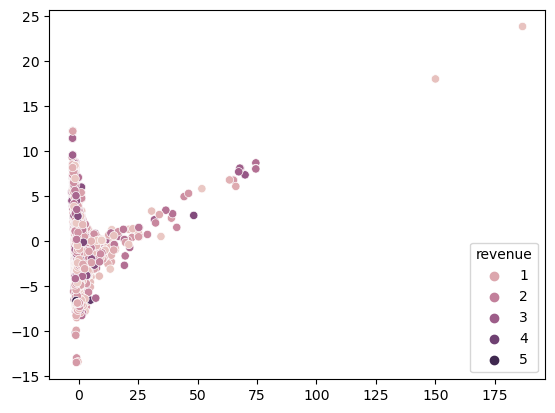

In [81]:
print(X_transformed.shape)
sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1], hue=y_train_scaled)


In [48]:
print(np.where([X_transformed[:,0] > 30]))
print(X_train.iloc[[ 289, 1071, 1472, 2336, 3217, 3682, 3727, 4014, 5416, 5568, 5969,
       6053, 6110, 6801, 7490, 8387]])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 289, 1071, 1472, 2336, 3217, 3682, 3727, 4014, 5416, 5568, 5969,
       6053, 6110, 6801, 7490, 8387]))
                                                  store_name  grunnkrets_id  \
store_id                                                                      
979718144-972930407-30634                     LOVUND VASK AS       18340113   
993324647-971693975-1284                KIWI MINI PRIS  ÅMLI        9290104   
880859722-980916146-44879                         JOKER ÅMLI        9290104   
993267279-990266492-76929                ÅMFOSS KAFETERIA AS        9290105   
916584032-916651503-817781               HALVORSEN BUTIKK AS        9290105   
984902832-984906560-161672                     PAN GARDEN AS        9290106   
895090042-974134179-35277               MATKROKEN NAUSTBUKTA       17510305   
979634021-971749059-15890                       JOKER LOVUND       18340113   
980520242-913249070-677241              

In [747]:
print(rmsle(y_test, np.expm1(y_lightgbm)))
# print(rmsle(y_test, np.expm1(y_lightgbm_2)))

print(rmsle(y_test, np.expm1(y_hat_grad)))
print(rmsle(y_test, np.expm1(y_histgradboost)))
ma = 100
best_i = 0
for i in range(0,100, 1):
    a=rmsle(y_test, np.average(np.vstack((np.expm1(y_lightgbm), np.expm1(y_histgradboost))), axis=0, weights=[i/100, 1-i/100]))
    if a< ma:
        ma = a
        best_i = i
print(ma, best_i)



0.7235557207015862
1.2804206876249389
0.7146385510122916
0.7053362497268939 46


In [ ]:
from yellowbrick.model_selection import feature_importances
import eli5
onehot_columns = pipe_forest.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out(input_features=categorical_features)
numeric_features_list = list(numeric_features.extend(X.select_dtypes(include=[np.bool8]).columns))
numeric_features_list.extend(onehot_columns)


In [ ]:
eli5.explain_weights(pipe_forest.named_steps['randomforestregressor'], top=200, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

In [30]:
eli5.explain_weights(pipe_ada.named_steps['adaboostregressor'], top=200, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

Explanation(estimator='AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=13,\n                                                       min_samples_leaf=5),\n                  learning_rate=0.001, n_estimators=20, random_state=42)', description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='chain_name_FLOYD BUTIKKDRIFT', weight=0.4237389434105198, std=0.027836769544805014, value=None), FeatureWeight(feature='lv4_3.6.1.0', weight=0.055427159729792036, std=0.040964016591986514, value=None), FeatureWeight(feature='chain_name_COOP EXTRA', weight=0.047569117910713915, std=0.02148902041069064, value=None), FeatureWeight(feature='lv3_2.3.3', weight=0.03339686020615721, std=0.0347707176154861, value=None), FeatureWeight(feature='district_name_Ørmelen', weight=0.03156265526776039, std=0.039304349403602924, value=None), FeatureWeight(feature='chain_name_ESSO NORGE', weight=0.027094785222846217, std=0.0404232335655359, value=None), FeatureWeight(feature='lv4_3.4.3.0', weight=0.019451705354324268, std=0.009393821201224724, value=None), FeatureWeight(feature='lv3_3.2.2', weight=0.015015297913906295, std=0.00909100843652822, value=None), FeatureWeight(feature='lv3_3.3.4', weight=0.013577301224329728, std=0.00868993790747702, value=None), FeatureWeight(feature='lv3_2.8.7', weight=0.013450609779698548, std=0.0070585892692268115, value=None), FeatureWeight(feature='lv3_3.2.4', weight=0.013299474254142686, std=0.012736270539573012, value=None), FeatureWeight(feature='lv3_2.9.9', weight=0.012731769932395125, std=0.010094804706715588, value=None), FeatureWeight(feature='lv3_2.8.6', weight=0.01170517976488577, std=0.005074272281751795, value=None), FeatureWeight(feature='lv3_3.2.1', weight=0.011207019390844406, std=0.0048134826046701325, value=None), FeatureWeight(feature='chain_name_BRANDSTAD', weight=0.010908026115058799, std=0.0067252976850535095, value=None), FeatureWeight(feature='municipality_name_Nærøy', weight=0.008850234762899081, std=0.014206222837430286, value=None), FeatureWeight(feature='lv3_3.3.2', weight=0.008684984495766952, std=0.004071741151270031, value=None), FeatureWeight(feature='district_name_Sør-Vågsøy', weight=0.008290922989183545, std=0.01117483118894473, value=None), FeatureWeight(feature='lv3_3.3.3', weight=0.007751210120940472, std=0.006996129767046234, value=None), FeatureWeight(feature='municipality_name_Vinje', weight=0.007379141542681868, std=0.0033366273164990713, value=None), FeatureWeight(feature='chain_name_BYGGTORGET', weight=0.0067905776235079734, std=0.008961450191579992, value=None), FeatureWeight(feature='municipality_name_Tingvoll', weight=0.00677667626233924, std=0.004162398981993164, value=None), FeatureWeight(feature='district_name_Vinger', weight=0.006254073076079439, std=0.002130677997794708, value=None), FeatureWeight(feature='district_name_Vikersund', weight=0.006056131935097293, std=0.0008486324963091415, value=None), FeatureWeight(feature='chain_name_EURO SKO NORGE', weight=0.005751459575943773, std=0.004986747562232253, value=None), FeatureWeight(feature='chain_name_HANSEN & DYSVIK', weight=0.005470893642680884, std=0.006676158202409576, value=None), FeatureWeight(feature='lv3_2.9.2', weight=0.004937660194807795, std=0.0049951877863845945, value=None), FeatureWeight(feature='lv3_2.9.7', weight=0.0046858967817927765, std=0.004447364317710817, value=None), FeatureWeight(feature='lv3_2.9.5', weight=0.004333539811903501, std=0.0030157633269886717, value=None), FeatureWeight(feature='lv3_2.9.1', weight=0.004073104189432173, std=0.004580584844892654, value=None), FeatureWeight(feature='municipality_name_Vaksdal', weight=0.003999197548038526, std=0.005446175821127405, value=None), FeatureWeight(feature='municipality_name_Sørfold', weight=0.003995404486677847, std=0.00483749831255722, value=None

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


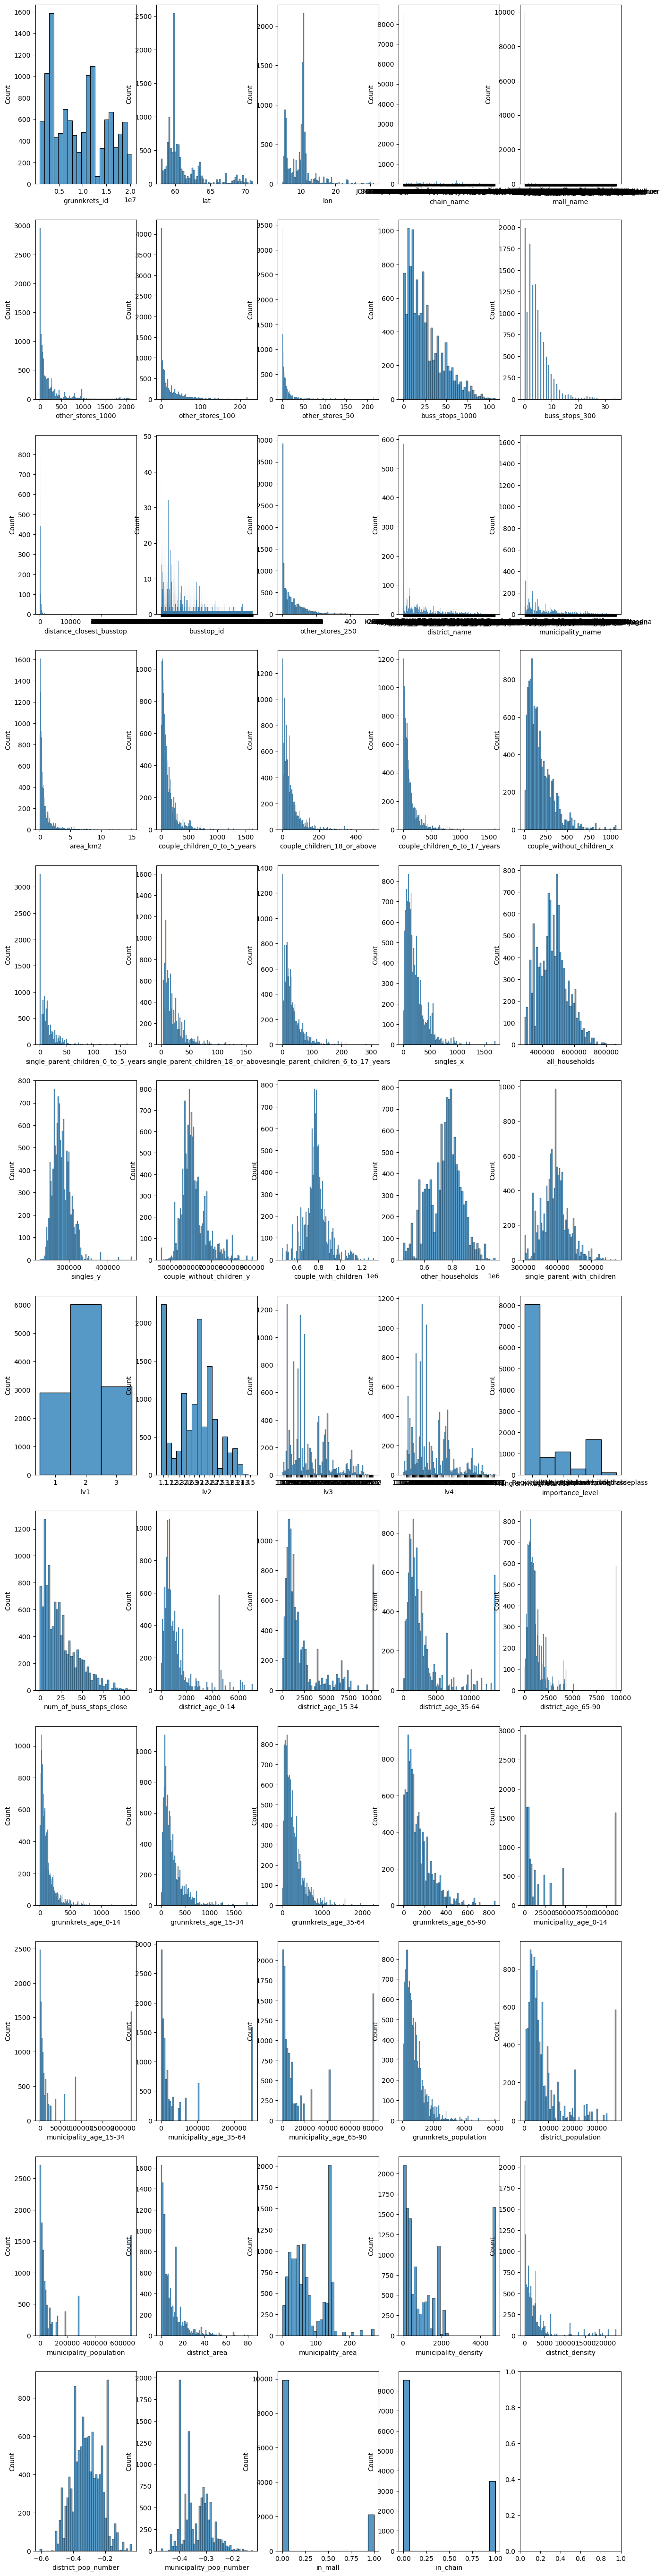

In [ ]:
import math
fig, axs = plt.subplots(nrows=math.ceil(len(list(X.columns.to_numpy()))/5), ncols=5, figsize=(16, 70))
for (i, col) in enumerate(X.columns):
    sns.histplot(X[col], ax=axs[math.floor(i/5)][i%5])

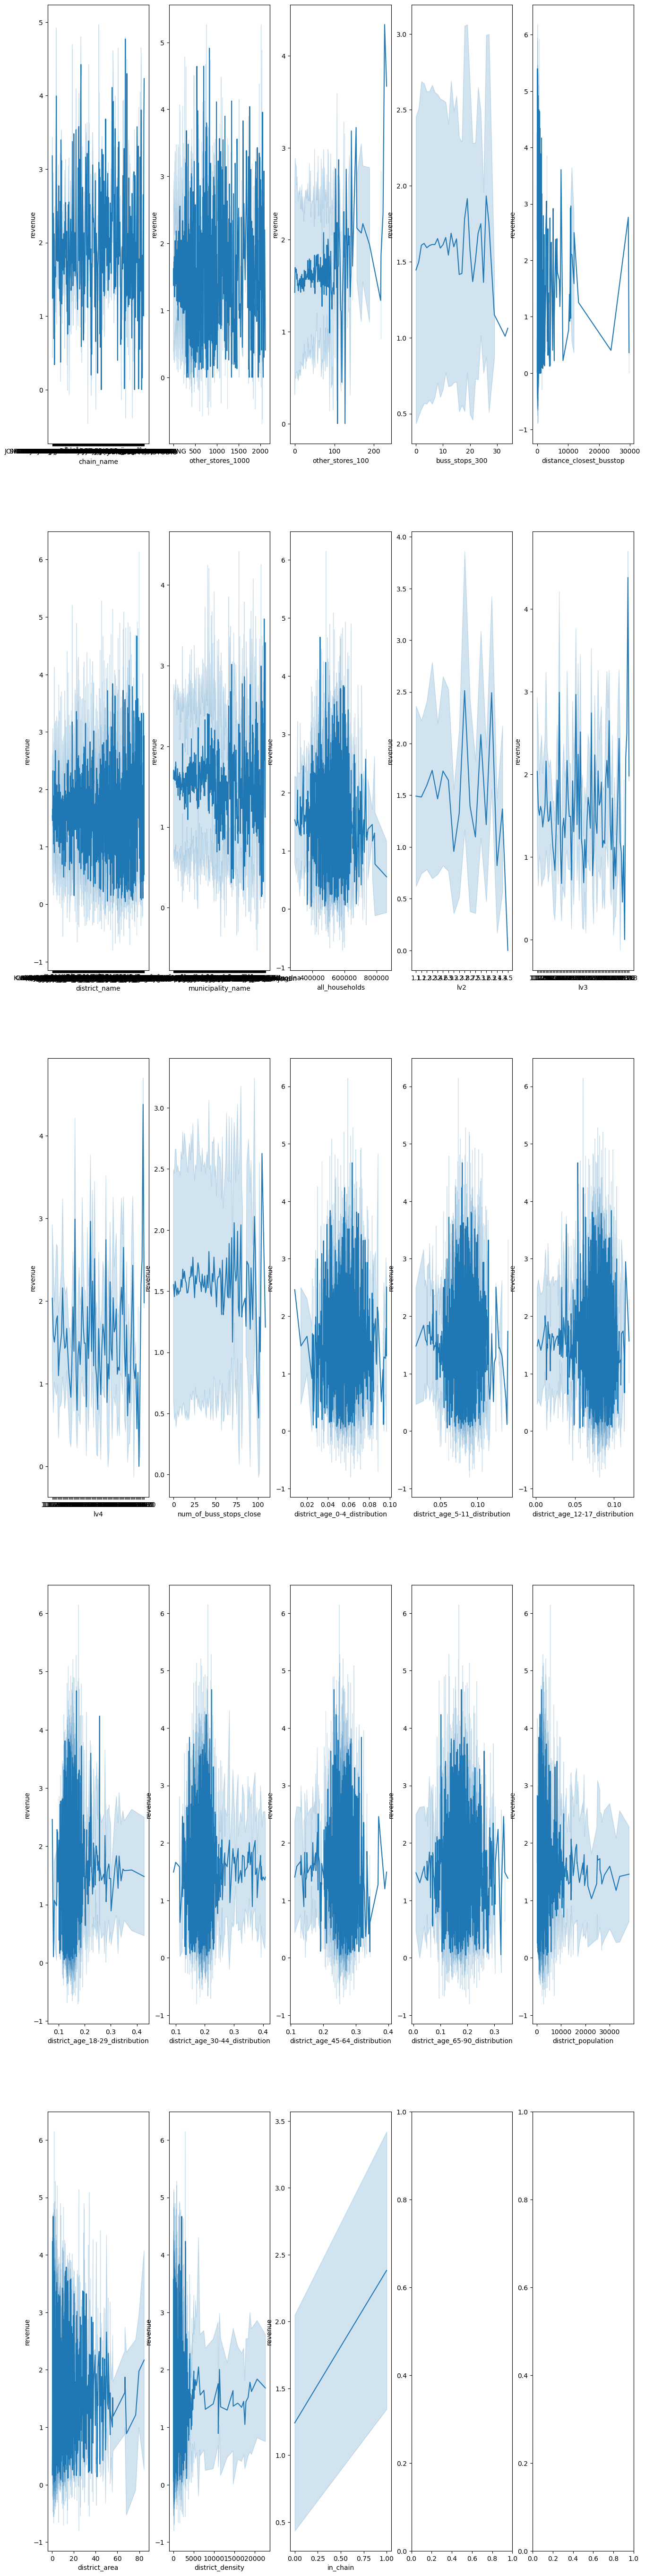

In [ ]:
import math
fig, axs = plt.subplots(nrows=math.ceil(len(list(X.columns.to_numpy()))/5), ncols=5, figsize=(16, 70))
for (i, col) in enumerate(X.columns):
    sns.lineplot(x=X[col], y=y_scaled, errorbar="sd", ax=axs[math.floor(i/5)][i%5])

c:\Users\haako\Anaconda3\envs\tdt4173\lib\site-packages\dython\nominal.py:289: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


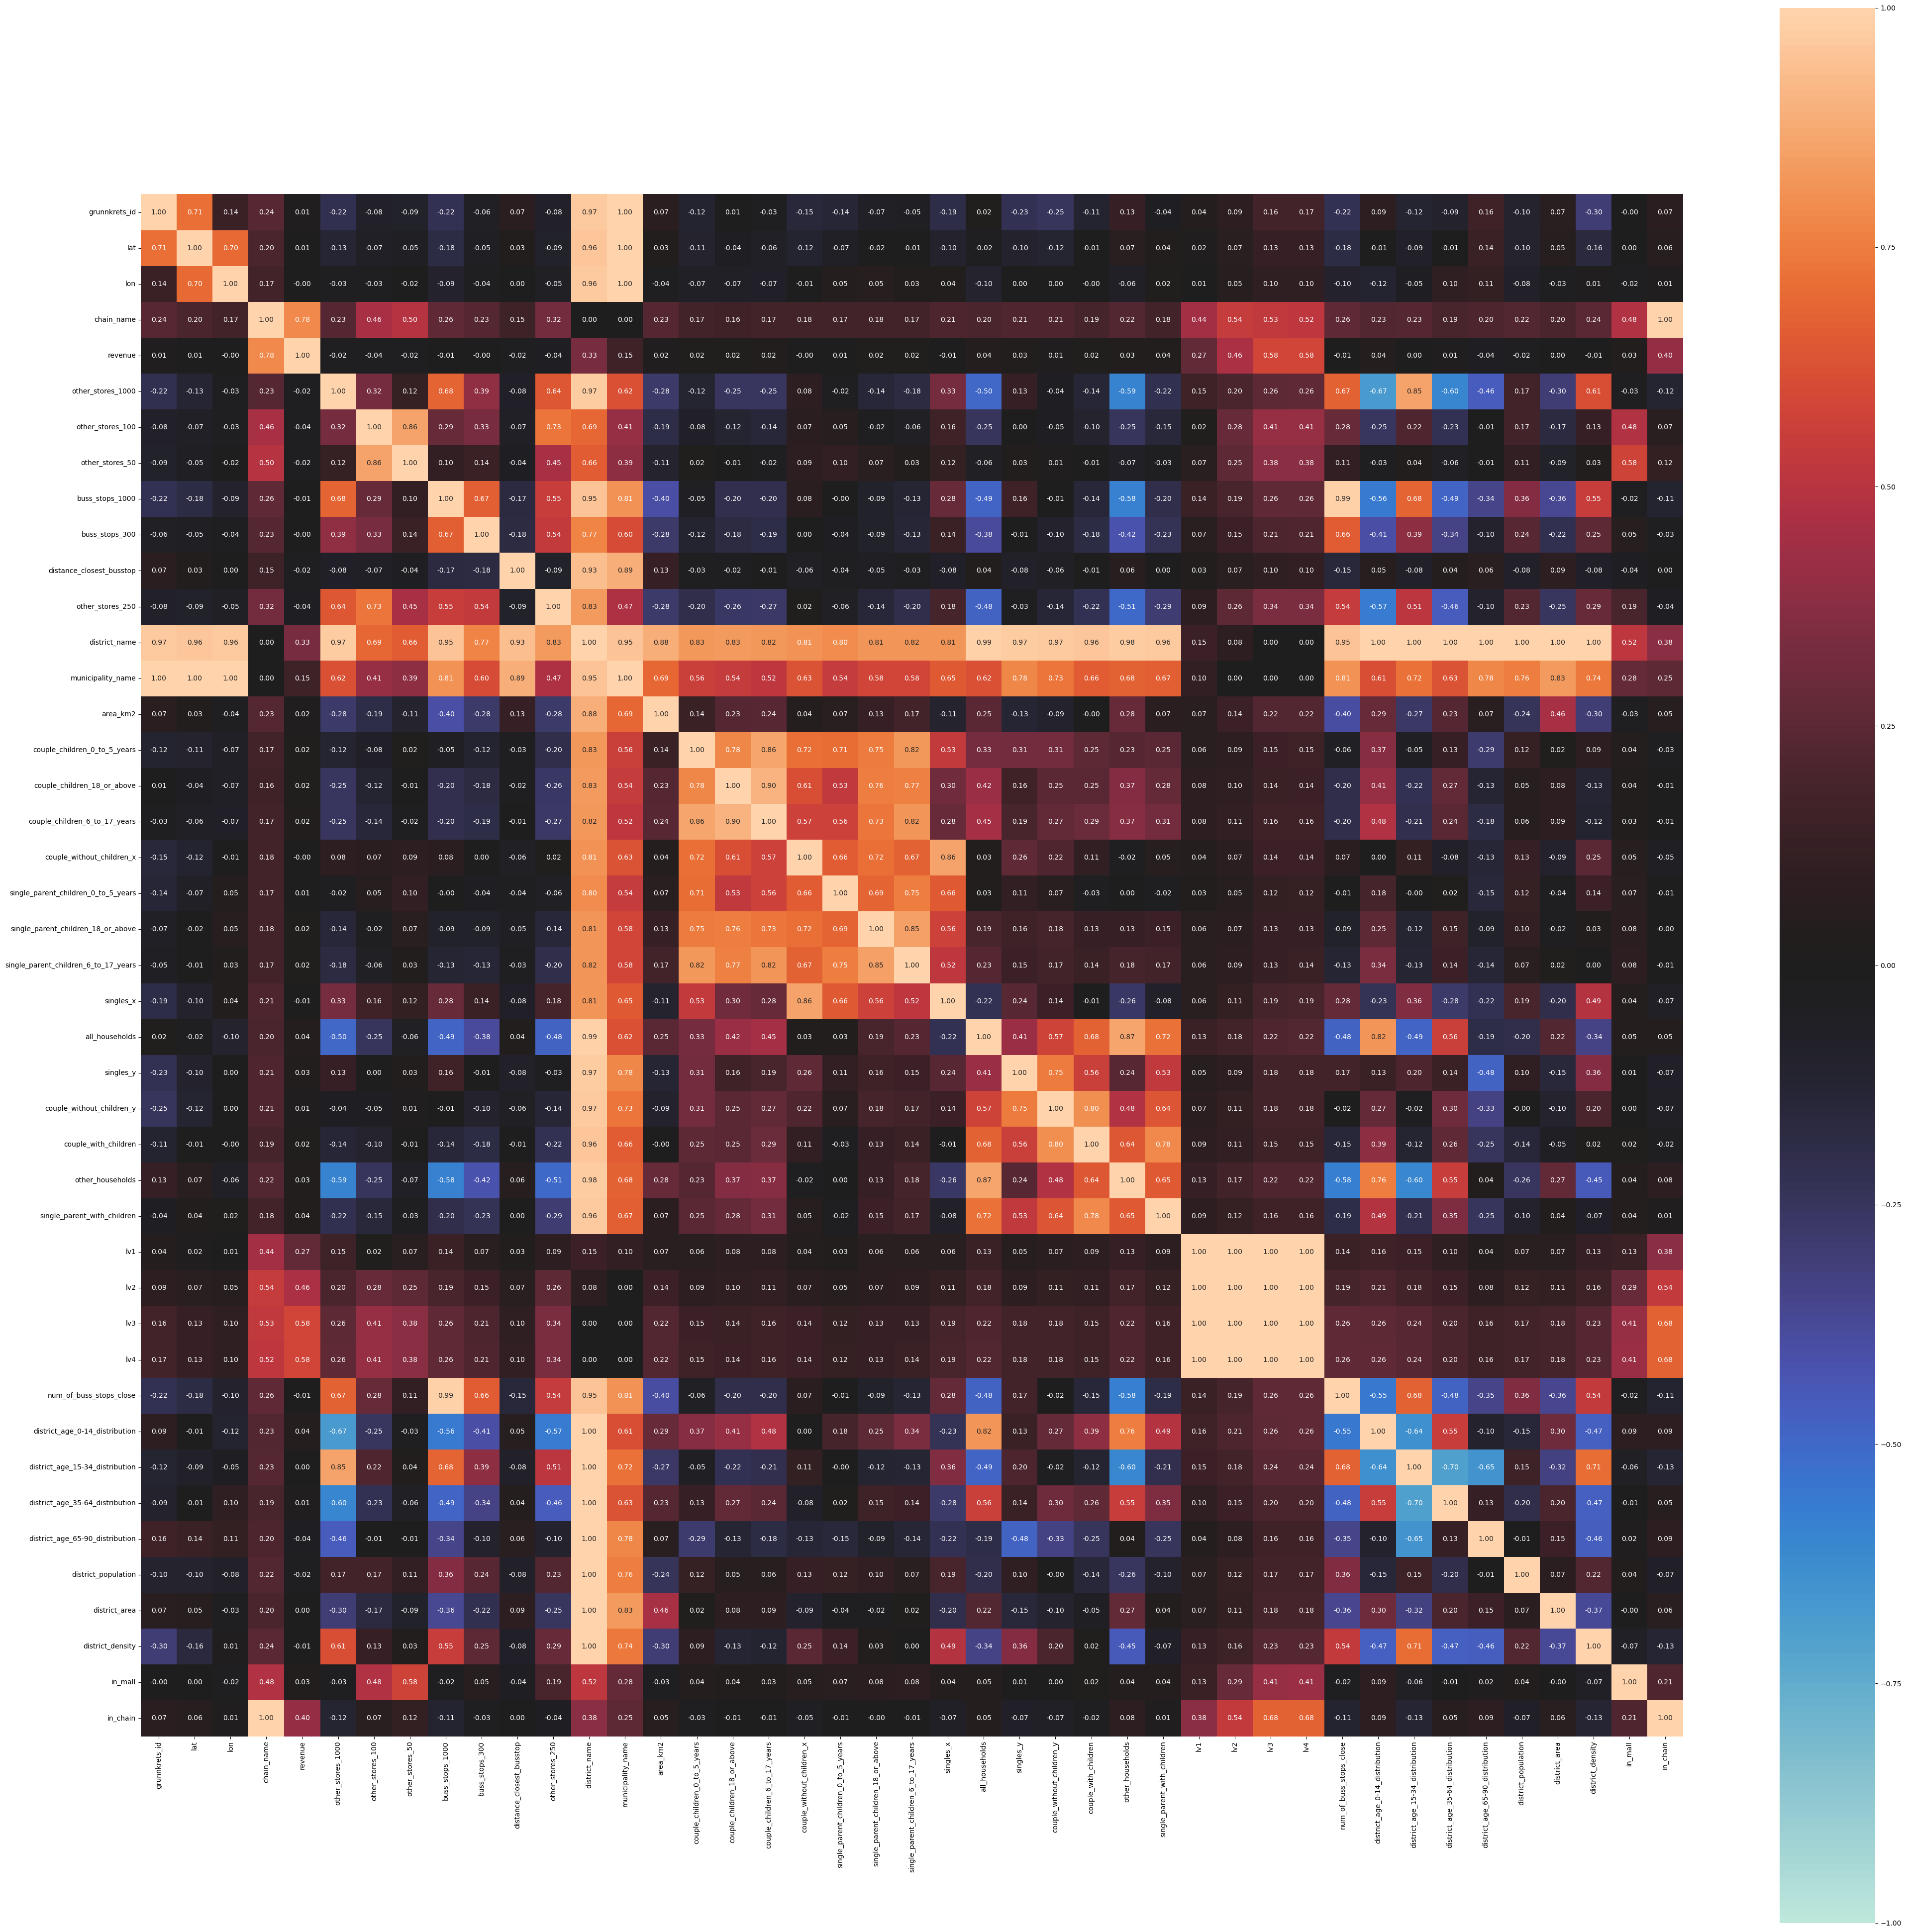

{'corr':                                       grunnkrets_id       lat       lon  \
 grunnkrets_id                              1.000000  0.713542  0.138201   
 lat                                        0.713542  1.000000  0.698669   
 lon                                        0.138201  0.698669  1.000000   
 chain_name                                 0.236595  0.200474  0.165804   
 revenue                                    0.014154  0.007474 -0.001296   
 other_stores_1000                         -0.216529 -0.131866 -0.026944   
 other_stores_100                          -0.084857 -0.068830 -0.031672   
 other_stores_50                           -0.090222 -0.051333 -0.015401   
 buss_stops_1000                           -0.224127 -0.182678 -0.093918   
 buss_stops_300                            -0.059177 -0.047422 -0.038236   
 distance_closest_busstop                   0.070796  0.029743  0.003673   
 other_stores_250                          -0.078296 -0.088139 -0.054733   
 dis

In [ ]:
associations(data_with_label, filename="../../figs/eda/stores_train_correlations_all_everything_low_income.png", figsize=(50,50))


8.111697611630333 8.1309062305296


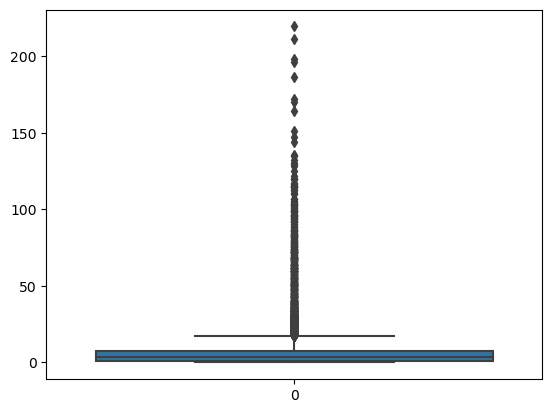

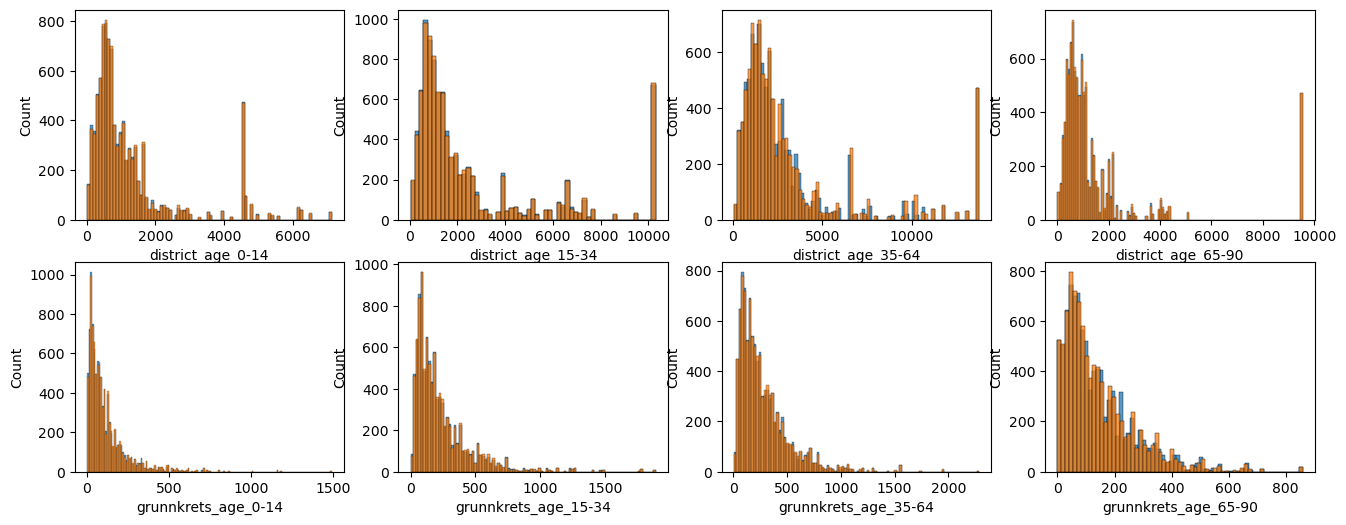

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, test_size=0.2, random_state=4)
sns.boxplot(y_train_4)
print(y_train_4.mean(), y_train.mean())
plt.show()
fig, axs = plt.subplots(nrows=2, ncols=len(ages)-1, figsize=(16, 6))
for i, name in enumerate(["district_age", "grunnkrets_age"]):
    for j in range(1, len(ages)):  
        age_from = ages[j-1]
        age_to = ages[j]
        sns.histplot(X_train_4[f"{name}_{age_from}-{age_to-1}"], ax=axs[i][j-1], )
        sns.histplot(X_train[f"{name}_{age_from}-{age_to-1}"], ax=axs[i][j-1])



